# October 4, 2020

## Plotting heatmap from actual data using the coordinate grid system

### Using track coordinates to populate data

There are two main applications I have in mind for heat maps, both relating to the wind extent data found in the HURDAT. Before using the wind extent data, I need to overcome a few major problems, which I will explain in greater detail in the next notebook.

The smaller step I would like to begin with is simply plotting the best track data (as I've done previously as scatter plots and lines) as a heatmap, with values of 1 when the storm center passed over a given 1-degree by 1-degree "cell", and values of 0 when it did not. 

This will result in a less precise graphic, but it's important to me that I understand how to correctly populate values in the `frequency_array` using data from the dataset before starting in on the more complex visualizations.

In [1]:
import os, sys
import pandas as pd

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

In [2]:
import numpy as np

# Create an array of zeros in the proper size.
frequency_array = np.zeros((180,360))

In [3]:
import pandas as pd

# Import our datasets.
positions = pd.read_csv('../data/02_intermediate/Atlantic_positions.csv', index_col = 0)
storms = pd.read_csv('../data/02_intermediate/Atlantic_storms.csv', index_col = 0)

I'll pick Hurricane Irma (2017) as the test case becuase its path was lengthy and passed along numerous geographic features which will make the accuracy of our plots easier to verify. We can start by using the functions we wrote previously to obtain its `stormID` and gather the longitude and latitude data for the track of its center.

After getting the latitude and longitude information, we can iterate through each coordinate represented by those lists and use the `math.floor()` function to find out the coordinate of the __Southwestern__ corner of the cell the center falls in. We care about the Southwestern corner in particular because we are using flat shading and our coordinate system increases as we move to the North and the East; in the frequency array, (0,0) which maps to (-180, -360) or (90S, 180W), is the "Southwesternmost" cell. So, by flooring our values, we can determine the unique cell in which the coordinate lies; for example, a storm located at 25.4N, 55.7W would be within the cell whose Southwestern coordinate is (25, -56). By changing this value in the frequency array, we can change the color of the entire cell between 25N and 26N and 55W and 56W.

Of course, the remaining consideration is that the frequency array begins numbering from 0,0, not -90,-180. So, we must adjust the values from our dataset by adding 90 to the latitude value (accounting for the negative values up to 90 degrees) and adding 180 to the longitude value (accounting for the negative values up to 180 degrees), and we find the value in the frequency array corresponding to (25, -56) is actually (115, 124).

In [4]:
from src.d07_visualization import storm_tracks as trk

# We'll use Hurricane Irma (2017) as our test case, so we'll store its stormID in a variable to simplify
# the later steps.
irma = trk.stormID("Irma", 2017)

In [5]:
from math import floor

# Now, we'll store the latitude and longitude information.
irma_lats = trk.track_lat(irma)
irma_lons = trk.track_lon(irma)

# For each coordinate, fill the appropriate cell in the frequency array with 1. All others remain 0.
# Remember to adjust our values to be in the range of the frequency array.
for i in range(len(irma_lats)):
    frequency_array[floor(90 + irma_lats[i])][floor(180 + irma_lons[i])] = 1

Now, using `pcolormesh` we can map this frequency array onto the globe as we did in the previous notebook.

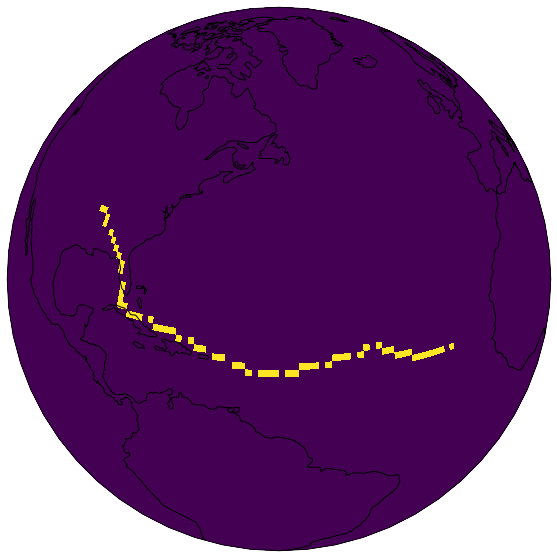

In [6]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

projection = ccrs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
lon = np.linspace(-180, 180, 361) # changed from 179
lat = np.linspace(-90, 90, 181) # changed from 89
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
ax.set_global()
ax.coastlines()
ax.pcolormesh(Lon, Lat, frequency_array, transform = ccrs.PlateCarree())


We see exactly what we expected! That is, a rather blocky representation of the track of the storm. This compares fairly favorably to the linear representation of the path, shown below.

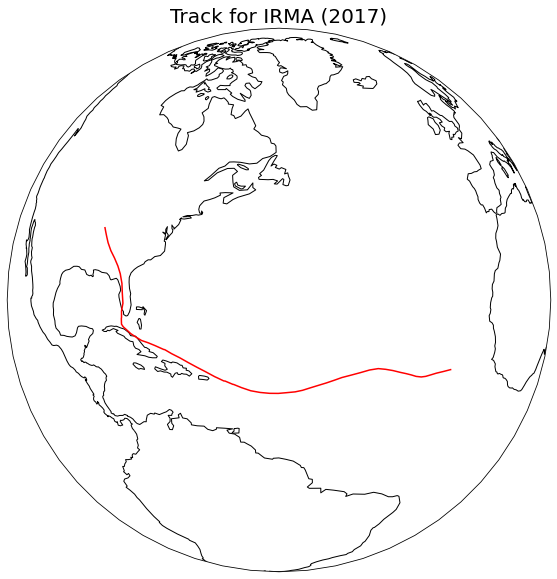

In [7]:
trk.plot_storm_track(irma, global_view = True, export = False)

My only other concern is that the 0 values fill most of the map with purple, which makes it rather hard to see the geography.

After some reading, I've learned that we can mask particular values using a masked array, a type of object in NumPy.

We can create a new masked array object, `frequency_array_transparent` by passing in our array, `frequency_array` and the value to mask, `0`.

In [8]:
frequency_array_transparent = np.ma.masked_equal(frequency_array, 0)

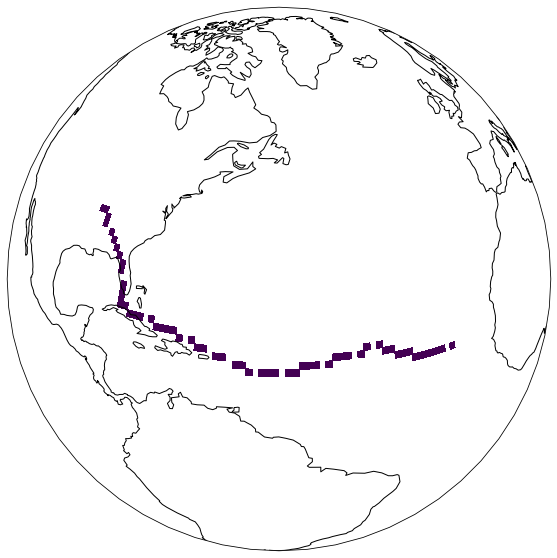

In [9]:
projection = ccrs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
lon = np.linspace(-180, 180, 361) # changed from 179
lat = np.linspace(-90, 90, 181) # changed from 89
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
ax.set_global()
ax.coastlines()
ax.pcolormesh(Lon, Lat, frequency_array_transparent, transform = ccrs.PlateCarree())

And just like that, we've been able to take storm data and create a (very basic) heatmap to plot on the world map!

The next challenge will be making the wind extent data usable; I'll discuss it in detail in the next notebook.